## Simple Banjo Simulation using FD method
Idea: A string with a rigid connection to square membrane   
  
Possible improvements:   
1. Multiple Strings
2. Non-Linear connection
3. Staircase Approximation of round membrane

In [109]:
import scipy.io.wavfile as wav
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Audio


### Initialize the variables

Common:
- Sample Rate: 44.1 kHz
- k: 1/fs
- sec: time of the sound 10s
- samples: sec * fs

In [110]:
# ========= Common =========
fs = 44100
k = 1/fs

sec = 1
samples = int(sec * fs)

print("Common Variables")
print("Sample Rate={:d}, k={:f}, seconds={:d}, sampels={:d}".format(fs, k, sec, samples))

Common Variables
Sample Rate=44100, k=0.000023, seconds=1, sampels=44100


#### String:


In [111]:
# ========= String =========
f0 = 440

sigma_0_s = 0.5 # damp
sigma_1_s = 0.005 # frequency depended damp

T_s = 138.67

r = 0.000415
I = np.pi * r**4 / 4
A = np.pi * r * r
E = 3000000000 # 210 GPa
rho = 1156

c_s = np.sqrt(T_s/(rho*A)) 
L = f0/c_s
h_s = c_s*k
N = int(np.floor(L/h_s))
h_s = L/N

kappa = np.sqrt(E*I/rho*A)

connection_idx_s = N - N // 10

a_s = ((c_s * k) / h_s)**2
b_s = (k*kappa)**2/(h_s**4)
c_s = 2*sigma_0_s*k
d_s = (2*sigma_1_s*k) / (h_s**2)

ck_sq = (c_s*k)**2
sg_k_4 = 4*sigma_1_s*k
stability_s = np.sqrt(0.5 * (ck_sq + sg_k_4 + np.sqrt((ck_sq + sg_k_4)**2 + 16*(kappa*k)**2)))

print("STRING: f0={:d}, L={:f}, N={:d}, h={:f}, A={:f}".format(f0,L,N,h_s,A))
print("damp={:f}, freq_damp={:f}, kappa={:f}, c=:{:f}".format(sigma_0_s, sigma_1_s, kappa,c_s))
print("a={:f}, b={:.15f}, c={:f}, d={:f}".format(a_s,b_s,c_s,d_s))
print("Stability | h={:.10f} >= {:.10f}".format(h_s, stability_s))

STRING: f0=440, L=0.934466, N=87, h=0.010741, A=0.000001
damp=0.500000, freq_damp=0.005000, kappa=0.000000, c=:0.000023
a=0.988128, b=0.000000000000001, c=0.000023, d=0.001966
Stability | h=0.0107409852 >= 0.0006734350


#### Membrane:
Banjo's head (membrane) is usualy made of Mylar Plastic
- E (young modulus): 3.8 GPa (3.8^10.9 Pa)
- H (thickness): .014" ~ 0.0003556m
- v(red. nu) (poissons ratio): 0.4
- rho (material density): 1380 # 1,38 g/cm³ -> 1380 kg/m³
- T (tension per unit length): 400 N/m 

In [143]:

# ========= Membrane ========= 
# M = 400
# f0_m = 391.99 # tune to G

sigma_0_m = 20 # damp
sigma_1_m = 0.009 # frequency depended damp

nu = 0.4 # poissons ratio
rho_m = 1380 # 1,38 g/cm³ -> 1380 kg/m³

T = 4000
E_m = 3800000000 # GPa (3.8^10.9 Pa)
H = 0.000355 # thickness

c_m = np.sqrt(T/(rho_m*H))
h_m = c_m*k # h := ck
L_m = 0.25 
M = 10 #int(np.floor(L/h_m))
h_m = L/M

D = (E_m * (H**3))/(12 * (1 - nu**2))
kappa_m = np.sqrt(D/(rho_m*H))

a_m = (c_m*k/h_m)**2
b_m = ((k*kappa_m)**2) / (h_m**4)
c_m = 2*sigma_0_m*k
d_m = (2*sigma_1_m*k) / (h_m**2)

connection_idx_m = int(M * 0.5)

ck_sq_m = (c_m*k)**2
sg_k_4_m = 4*sigma_1_m*k
stability_m = np.sqrt(ck_sq_m + sg_k_4_m + np.sqrt((ck_sq_m + sg_k_4_m)**2 + 16*(kappa_m*k)**2))

print("MEMBRANE: M={:d}".format(M))
print("Physical Properties | T(tension per unit)={:f} | \n \
      E(young)={:f} | H(thickness)={:f}, v(poissons ratio)={:f}, rho(density)={:f}".format(T,E_m,H,nu,rho_m))
print("c_m={:f}, h_m={:f}, M={:d}, L={:f}".format(c_m, h_m, M, L_m))
print("D={:.15f}, kappa={:.10f}".format(D,kappa_m))
print("a={:f}, b={:.15f}, c={:f}, d={:f}".format(a_m,b_m,c_m,d_m))
print("Stability | h={:.10f} >= {:.10f}".format(h_m, stability_m))



MEMBRANE: M=10
Physical Properties | T(tension per unit)=4000.000000 | 
       E(young)=3800000000.000000 | H(thickness)=0.000355, v(poissons ratio)=0.400000, rho(density)=1380.000000
c_m=0.000907, h_m=0.093447, M=10, L=0.250000
D=0.016865845734127, kappa=0.1855454642
a=0.000481, b=0.000000232150717, c=0.000907, d=0.000047
Stability | h=0.0934465708 >= 0.0042030505


### Initialize the states

String State: `u` N x 3  
- Next `u[:,0]` 
- Current `u[:,1]` 
- Prev `u[:,2]` 

Membrane State: `w` M x M x 3
- Next `w[:,:,0]` 
- Current `w[:,:,1]` 
- Prev `w[:,:,2]` 

In [146]:
def init_states():
    u = np.zeros((N, 3))
    w = np.zeros((M, M, 3))

    u[3:10, 1] = np.hanning(7)

    output = np.zeros(samples)
    return u, w, output

### Calculate output

In [114]:
def wave_s(u, l, n=1):
    return u[l+1,n] - 2*u[l,n] + u[l-1,n]

def stiff_s(u,l,n=1):
    return u[l+2,n] - 4*u[l+1,n] + 6*u[l,n] - 4*u[l-1,n] + u[l-2,n]

def damp_s(u, l,n=1):
    return u[l,n] - u[l,n+1]

def freq_damp_s(u, l, n=1):
    return wave_s(u,l,n) - wave_s(u,l,n+1)

def fd_string(u):
    for l in range(2,N-3):
        u[l,0] = 2*u[l,1] - u[l,2] + a_s * wave_s(u,l) - b_s * stiff_s(u,l) - c_s * damp_s(u, l) + d_s * freq_damp_s(u,l) 

    # Boundry Conditions, first and last element are 0, -1 and N+1 are same as second and second to last but opposite sign
    u[1,0] = 2*u[1,1] - u[1,2] + wave_s(u,1) - b_s * (u[3,1] - 4*u[2,1] + 5*u[1,1]) - c_s * damp_s(u, 1) + d_s * freq_damp_s(u,1) 
    u[N-2,0] = 2*u[N-2,1] - u[N-2,2] + wave_s(u, N-2) - b_s *(5*u[N-2,1] - 4*u[N-3,1] + u[N-4,1])  - c_s * damp_s(u, N-2) + d_s * freq_damp_s(u,N-2) 
    

    return u

In [121]:
def wave_m(w, l, m, n=1):
    return w[l+1,m,n] + w[l-1,m,n] + w[l,m+1,n] + w[l,m-1,n] - 4*w[l,m,n] 

def stiff_m(w, l, m, n=1):
    return 20*w[l,m,n] - 8*(w[l+1,m,n] +w[l-1,m,n] + w[l,m+1,n] + w[l,m-1,n]) + 2*(w[l+1,m+1,n] + w[l-1,m+1,n] + w[l+1,m-1,n] + w[l-1,m-1,n]) + (w[l+2,m,n] + w[l-2,m,n] + w[l,m+2,n] + w[l,m-2,n]) 

def damp_m(w, l, m, n=1):
    return w[l,m,n] - w[l,m,n+1]

def freq_damp_m(w, l, m, n=1):
    return wave_m(w,l,m,n) - wave_m(w,l,m,n+1)

def fd_membrane(w):
    for l in range(2,M-3):
        for m in range(2,M-3):
            w[l,m,0] = 2*w[l,m,1] - w[l,m,2] + a_m * wave_m(w,l,m) - b_m * stiff_m(w,l,m) - c_m * damp_m(w,l,m) + d_m * freq_damp_m(w,l,m) 

    # Circle like structure
    r = M // 2
    center = M // 2

    # Draw a circle of 0s in the middle of the matrix
    y, x = np.ogrid[-center:M-center, -center:M-center]
    mask = x*x + y*y >= r*r
    w[:,:,0][mask] = 0

    # Boundry Conditions, first and last element are 0, -1 and N+1 are same as second and second to last but opposite sign
    #w[1,0] = 2*u[1,1] - u[1,2] + wave_s(u,1) - b * (u[3,1] - 4*u[2,1] + 5*u[1,1]) - c * damp_s(u, 1) + d * freq_damp_s(u,1) 
    #w[N-2,0] = 2*u[N-2,1] - u[N-2,2] + wave_s(u, N-2) - b *(5*u[N-2,1] - 4*u[N-3,1] + u[N-4,1])  - c * damp_s(u, N-2) + d * freq_damp_s(u,N-2) 
    
   
    return w

In [116]:
connection_s = k**2 / (rho*A*h_s)
connection_m = k**2 / (rho_m*H*h_m)

def fd_connection(u, w, u_lc, w_lc):
    f = (w[w_lc, w_lc, 0] - u[u_lc, 0]) / ( connection_s + connection_m)

    u[u_lc, 0] += f*connection_s
    w[w_lc, w_lc, 0] -= f*connection_m
    return u, w

def fd_move(u,w):
    # Move the grid one step forward in time
    u[:,2] = u[:,1]
    u[:,1] = u[:,0]
    
    # Move the grid one step forward in time
    w[:,:,2] = w[:,:,1]
    w[:,:,1] = w[:,:,0]

    return u,w

In [147]:
def run():
    u, w, output = init_states()
    
    for i in range(samples):
        u = fd_string(u)
        w = fd_membrane(w)
        u, w = fd_connection(u, w, connection_idx_s, connection_idx_m)
        u, w = fd_move(u,w)

        output[i] =  w[int(M/2), int(M/2), 0] +u[int(N/2), 0] 

    return output



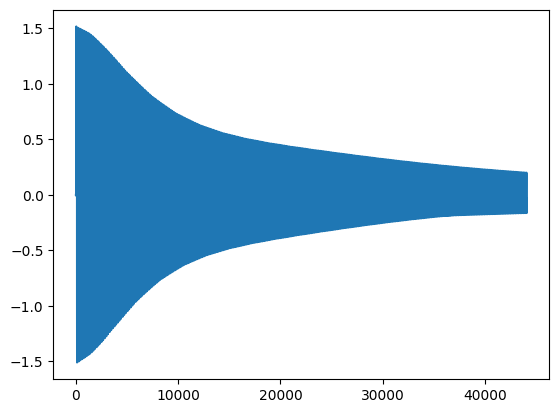

In [148]:
out = run()
plt.plot(out)
plt.show()
display(Audio(data=out, rate = fs))

### Plot Spectogram

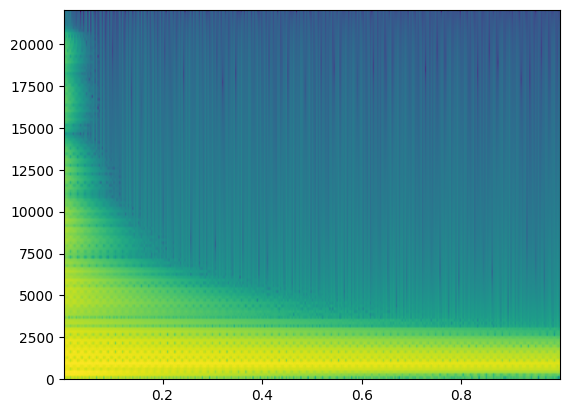

In [149]:
plt.specgram(out[:int(len(out)/sec)], Fs=fs)
plt.show()

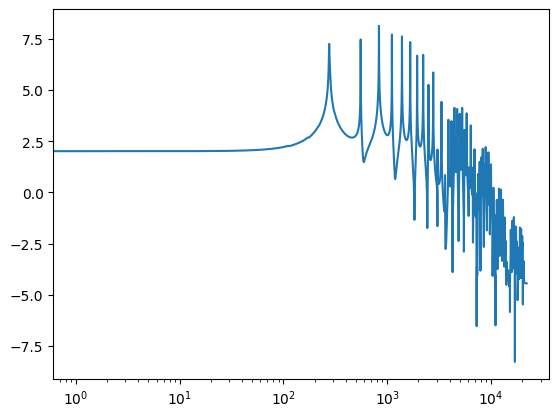

In [150]:
yf = np.fft.fft(out)
plt.plot(np.log(np.abs(yf[:fs//2])))
plt.xscale("log")
plt.show()